# Предсказание стоимости автомобилей

### Содержание

##### Часть 1. Общие данные:
* [1. Описание проекта](#section0.1)
* [2. Описание данных](#section0.2)
* [3. Загрузка библиотек](#section0.3)
* [4. Загрузка данных](#section0.4)

##### Часть 2. Подготовка данных:
* [1. Изучение данных](#section1.1)
* [2. Обработка пропусков и дубликатов](#section1.2)
* [3. Обработка выбросов и аномальных значений](#section1.3)
* [4. Подготовка выборок для обучения](#section1.4)

##### Часть 3. Обучение моделей:
* [1. Линейная регрессия](#section2.1)
* [2. LightGBM](#section2.2)
* [3. CatBoost](#section2.3)

##### Часть 3. Анализ моделей:
* [1. Анализ моделей](#section3)

# Общие данные

## Описание проекта <a id='section0.1'></a>

Имеются исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Для оуенки модели важны следующие параметры:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных <a id='section0.2'></a>

Признаки
+ DateCrawled — дата скачивания анкеты из базы
+ VehicleType — тип автомобильного кузова
+ RegistrationYear — год регистрации автомобиля
+ Gearbox — тип коробки передач
+ Power — мощность (л. с.)
+ Model — модель автомобиля
+ Kilometer — пробег (км)
+ RegistrationMonth — месяц регистрации автомобиля
+ FuelType — тип топлива
+ Brand — марка автомобиля
+ NotRepaired — была машина в ремонте или нет
+ DateCreated — дата создания анкеты
+ NumberOfPictures — количество фотографий автомобиля
+ PostalCode — почтовый индекс владельца анкеты (пользователя)
+ LastSeen — дата последней активности пользователя

Целевой признак
+ Price — цена (евро)

## Загрузим библиотеки <a id='section0.3'></a>

In [1]:
# Импортируем библиотеки
# для работы с данными
import pandas as pd
import numpy as np

# для работы с датой
import datetime

#Предупреждения
import warnings
warnings.filterwarnings('ignore')

#для загрузки данных
from pathlib import Path
import os
import urllib.request

# Для Графиков
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
matplotlib.style.use('ggplot')

#для построения моделей
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

from sklearn.metrics import mean_squared_error

#Для фиксации времени
from timeit import default_timer as timer

#Для визуализации процесса
from tqdm.notebook import tqdm

## Загрузим данные <a id='section0.4'></a>

In [2]:
#Cоздадим папку если ее нет
Path('datasets').mkdir(parents=True, exist_ok=True)

#словарь с именем файла и ссылкой на него
urls = {
    'autos': ('/datasets/autos.csv', 'https://code.s3.yandex.net/datasets/autos.csv')
}

def get_file(file_name, url):
    #Проверим есть ли файл
    if not os.path.exists(file_name):
        print(file_name, 'файл не найден, будет загружен из сети')
        #качаем файл по ссылке url, кладем по пути file_name
        _ = urllib.request.urlretrieve(url, file_name)

[get_file(*urls[k]) for k in urls]
     
data = pd.read_csv(urls['autos'][0])

# 1. Подготовка данных

## 1.1. Загрузим и изучим данные <a id='section1.1'></a>

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
(data.isnull().sum() / data.shape[0]).sort_values(ascending=False).apply(lambda x: '{:0.2%}'.format(x))

NotRepaired          20.08%
VehicleType          10.58%
FuelType              9.28%
Gearbox               5.60%
Model                 5.56%
LastSeen              0.00%
PostalCode            0.00%
NumberOfPictures      0.00%
DateCreated           0.00%
Brand                 0.00%
RegistrationMonth     0.00%
Kilometer             0.00%
Power                 0.00%
RegistrationYear      0.00%
Price                 0.00%
DateCrawled           0.00%
dtype: object

In [6]:
data.duplicated().sum()

4

In [7]:
data.loc[data.duplicated() == True]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [8]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['DateCreated'] = pd.to_datetime(data['DateCreated'])
data['LastSeen']    = pd.to_datetime(data['LastSeen'])

In [9]:
pd.options.display.float_format = '{:.2f}'.format
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.00,354369.00,354369.00,354369.00,354369.00,354369.00,354369.00
mean,4416.66,2004.23,110.09,128211.17,5.71,0.00,50508.69
std,4514.16,90.23,189.85,37905.34,3.73,0.00,25783.10
min,0.00,1000.00,0.00,5000.00,0.00,0.00,1067.00
25%,1050.00,1999.00,69.00,125000.00,3.00,0.00,30165.00
50%,2700.00,2003.00,105.00,150000.00,6.00,0.00,49413.00
75%,6400.00,2008.00,143.00,150000.00,9.00,0.00,71083.00
max,20000.00,9999.00,20000.00,150000.00,12.00,0.00,99998.00


In [10]:
data.describe(include=[object])

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
count,316879,334536,334664,321474,354369,283215
unique,8,2,250,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,91457,268251,29232,216352,77013,247161


In [11]:
data.describe(include=[np.datetime64])

,DateCrawled,DateCreated,LastSeen
count,354369,354369,354369
unique,271174,109,179150
top,2016-03-24 14:49:47,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,13719,17
first,2016-03-05 14:06:22,2014-03-10 00:00:00,2016-03-05 14:15:08
last,2016-04-07 14:36:58,2016-04-07 00:00:00,2016-04-07 14:58:51


In [12]:
DATA_ORIGIN_SIZE = data.shape[0]

Проверим зависимость цены от года выпуска для самой популярной модели

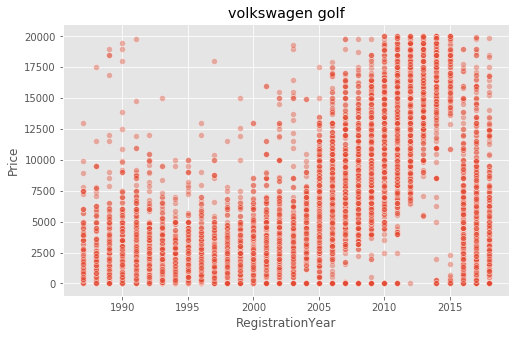

In [13]:
sns.scatterplot(x=data.loc[(data.Brand == 'volkswagen') & (data.Model == 'golf') & 
                           (data.RegistrationYear > 1986) & (data.RegistrationYear < 2020),
                           'RegistrationYear'],
                y=data.loc[(data.Brand == 'volkswagen') & (data.Model == 'golf') & 
                           (data.RegistrationYear > 1986) & (data.RegistrationYear < 2020),
                           'Price'],
                alpha=.4)
plt.title('volkswagen golf')

plt.show()

## Вывод

1. Данные загружены, произведен первичный анализ
2. Наблюдается наличие пропусков в данных, а также дубликаты
3. Наблюдаются артефактные значения такие как слишком большое/маленькое значение года регистрации, нулевые значения цены автомобиля, нулевые значения месяца
4. При построении скаттерплота цены от года выпуска наблюдается аномальное поведение цены после 2015 года, также наблюдается аномальное(слишком высокое) значение цены автомобилей для ранних годов. Что может быть как следствием некорректной цены, так и причиной дополнительных, неучтенных характеристик автомобиля (например автомобиль GT и т.п.)

## 1.2. Проверим пропуски и удалим дубликаты <a id='section1.2'></a>

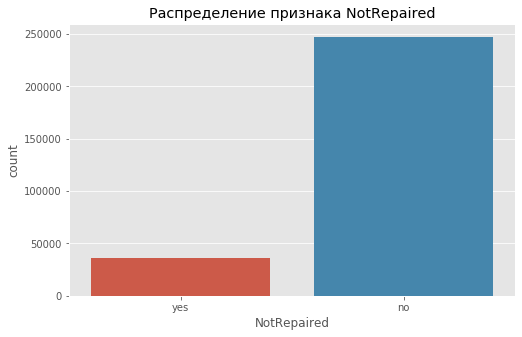

In [14]:
sns.countplot(data['NotRepaired'])
plt.title('Распределение признака NotRepaired')
plt.show()

Примем, что пропуски в колонке `NotRepaired` связаны с тем, что пользователь пропустил этот признак по причине того, что машина не ремонтировалась и пользователь посчитал этот признак не важным для указания в объявлениию.<br/>
Заменим пропуски на 'no' и приведем к виду числовому виду

In [15]:
data.loc[data.NotRepaired == 'no', 'NotRepaired'] = 0
data.loc[data.NotRepaired == 'yes', 'NotRepaired'] = 1

In [16]:
data.NotRepaired.fillna(0, inplace=True)

In [17]:
cols = ['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode']

In [18]:
data[cols].duplicated().sum()

11292

Удалим дубликаты, вероятнее всего т.к. совпадает почтовый индекс и описание машины, то один и тот же пользователь несколько раз подавал объявление на туже машину

In [19]:
index_of_duples = data.loc[data[cols].duplicated() == True].index

In [20]:
data.drop(labels=index_of_duples, axis=0, inplace=True)

In [21]:
print('Удалили', round((1 - data.shape[0] / DATA_ORIGIN_SIZE)*100, 2), '% данных при удалении дубликатов')

Удалили 3.19 % данных при удалении дубликатов


In [22]:
data[cols].duplicated().sum()

0

In [23]:
DATA_AFTER_DUPL_DELETED = data.shape[0]

Просуски в объектах, касающиеся описания автомобилей, будем заполнять на основании наиболее часто встречающихся значениях при прочих равных характеристиках

In [24]:
def car_description_imputer(df, feature_cols, target_col):
    
    _cols = feature_cols.copy()
    _cols.append(target_col)
    _car_description_list = df[_cols].pivot_table(values=target_col,
                                     index=feature_cols,
                                     aggfunc='count').index
    for elem in tqdm(_car_description_list):

        _queries = []
        for i in range(len(elem)):
            _query = df[feature_cols[i]] == elem[i]
            _queries.append(_query)

        if   len(_car_description_list[0]) == 1:
            _query = _queries[0]
        elif len(_car_description_list[0]) == 2:     
            _query = _queries[0] & _queries[1]
        elif len(_car_description_list[0]) == 3:     
            _query = _queries[0] & _queries[1] & _queries[2]
        elif len(_car_description_list[0]) == 4:     
            _query = _queries[0] & _queries[1] & _queries[2] & _queries[3]
        elif len(_car_description_list[0]) == 5:     
            _query = _queries[0] & _queries[1] & _queries[2] & _queries[3] & _queries[3]
        else:
            print('Слишком длинный список признаков')
            #break

        try:
            _ = df.loc[_query, target_col].mode()[0]
            df.loc[_query & (df[target_col].isnull()), target_col] = (
                df.loc[_query & (df[target_col].isnull()), target_col]\
                .fillna(_)
            )
        except IndexError:
            pass

In [25]:
target_col = 'Gearbox'
feature_cols = ['Brand', 'Model']
car_description_imputer(data, feature_cols, target_col)

Для использования мощности двигателя в качестве описательной характеристики удалим аномали, которые изначально обраружили при первичном анализе данных

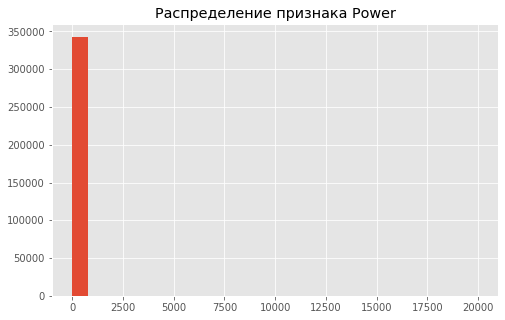

In [26]:
plt.hist(data['Power'], bins=25)
plt.title('Распределение признака Power')
plt.show()

удалим 0,05% от верхней границы диапазона, т.к. величина мощности двигателя сильно больше "адекватным" значениям серийных автомобилей

In [27]:
data = data.loc[data.Power < data.Power.quantile(.995)]

В качестве заполнения нулевых значений мощности будем использовать медианное значение при соответствии бренда и модели авто

In [28]:
_cars_brand_model = data.groupby(by=['Brand', 'Model']).count().index

for elem in tqdm(_cars_brand_model):
    _brand = elem[0]
    _model = elem[1]
    _query = (data.Brand == _brand) & (data.Model == _model)
    data.loc[_query & (data.Power == 0), 'Power'] = data.loc[_query, 'Power'].median()

In [29]:
data.loc[data.Power == 0].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
115,2016-03-20 18:53:27,0,small,1999,NaN,0.00,NaN,5000,0,petrol,volkswagen,0,2016-03-20,0,37520,2016-04-07 02:45:22
160,2016-03-19 19:49:15,500,small,1999,manual,0.00,NaN,150000,0,petrol,renault,0,2016-03-19,0,26969,2016-04-01 11:17:48
260,2016-04-04 09:49:59,450,NaN,2016,manual,0.00,NaN,150000,3,petrol,mitsubishi,0,2016-04-04,0,59302,2016-04-06 11:17:11
306,2016-03-21 14:38:37,200,NaN,2009,NaN,0.00,NaN,10000,0,NaN,sonstige_autos,0,2016-03-21,0,6493,2016-03-24 02:47:34
308,2016-03-13 13:38:54,1600,wagon,1999,manual,0.00,NaN,150000,6,petrol,bmw,0,2016-03-13,0,41199,2016-03-28 12:46:35


Для оставшихся нулевых значений наблюдается недостаток признаков, для надежного заполнения пропусков, восстановить мощность только по названию модели может сильно повлиять на качество модели, поэтому удалим оставшиеся нулевые значения

In [30]:
data = data.loc[data.Power > 0]

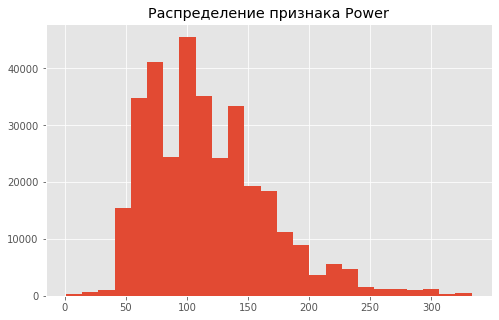

In [31]:
plt.hist(data['Power'], bins=25)
plt.title('Распределение признака Power')
plt.show()

По гистограмме распределения надлюдается несколько групп автомобилей, которые сильно отличаются по мощности двигателя, что впринципе соответствует нашим представлениям о автомобилях

Продолжим заполнять пропуски при описании характеристик автомобиля

In [32]:
target_col = 'Model'
feature_cols = ['Brand', 'Power']
car_description_imputer(data, feature_cols, target_col)

In [33]:
target_col = 'FuelType'
feature_cols = ['Model', 'Power']
car_description_imputer(data, feature_cols, target_col)

In [34]:
target_col = 'VehicleType'
feature_cols = ['Brand', 'Model']
car_description_imputer(data, feature_cols, target_col)

Для оставшихся автомобилей недосаточно данных для надежного заполнения пропусков, поэтому удалим их

In [35]:
data.dropna(axis=0, inplace=True)

Удалим дубликаты

In [36]:
data.drop_duplicates(inplace=True)

In [37]:
print('Удалили', round((1 - data.shape[0] / DATA_AFTER_DUPL_DELETED)*100, 2), '% данных при восстановлении пропусков')

Удалили 3.24 % данных при восстановлении пропусков


In [38]:
print('Удалили', round((1 - data.shape[0] / DATA_ORIGIN_SIZE)*100, 2), '% данных при обработке в целом')

Удалили 6.32 % данных при обработке в целом


In [39]:
DATA_AFTER_NULL_FIXED = data.shape[0]

## 1.3. Прорверим выбросы и аномальные значения <a id='section1.3'></a>

In [40]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NotRepaired,NumberOfPictures,PostalCode
count,331960.00,331960.00,331960.00,331960.00,331960.00,331960.00,331960.00,331960.00
mean,4407.04,2003.87,117.19,128742.38,5.77,0.10,0.00,50631.51
std,4480.46,68.47,49.59,37169.10,3.70,0.30,0.00,25787.57
min,0.00,1000.00,1.00,5000.00,0.00,0.00,0.00,1067.00
25%,1100.00,1999.00,75.00,125000.00,3.00,0.00,0.00,30177.00
50%,2750.00,2003.00,109.00,150000.00,6.00,0.00,0.00,49477.00
75%,6350.00,2008.00,143.00,150000.00,9.00,0.00,0.00,71263.00
max,20000.00,9999.00,333.00,150000.00,12.00,1.00,0.00,99998.00


### 1.3.1. Год регистрации

In [41]:
data.RegistrationYear.sort_values().unique()

array([1000, 1001, 1111, 1234, 1300, 1500, 1602, 1800, 1910, 1919, 1923,
       1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1941, 1942, 1943, 1945, 1947, 1949, 1950, 1951, 1952, 1953,
       1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964,
       1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2066, 2200, 2290, 2500, 2800, 2900, 3000, 3700, 4000, 4500, 5000,
       5555, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8500, 9000, 9999])

Удалим автомобили ранее 1910 года и позднее текущего года

In [42]:
data = data.loc[
    (data.RegistrationYear > 1909) &
    (data.RegistrationYear < pd.datetime.today().year)
]

In [43]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NotRepaired,NumberOfPictures,PostalCode
count,331876.00,331876.00,331876.00,331876.00,331876.00,331876.00,331876.00,331876.00
mean,4407.44,2003.18,117.19,128772.79,5.77,0.10,0.00,50632.98
std,4480.35,7.22,49.59,37123.76,3.70,0.30,0.00,25787.55
min,0.00,1910.00,1.00,5000.00,0.00,0.00,0.00,1067.00
25%,1100.00,1999.00,75.00,125000.00,3.00,0.00,0.00,30177.00
50%,2750.00,2003.00,109.00,150000.00,6.00,0.00,0.00,49477.00
75%,6350.00,2008.00,143.00,150000.00,9.00,0.00,0.00,71263.00
max,20000.00,2019.00,333.00,150000.00,12.00,1.00,0.00,99998.00


In [44]:
def low_treshhold (column):
    return column.quantile(.25) - 1.5 * (column.quantile(.75) - column.quantile(.25))

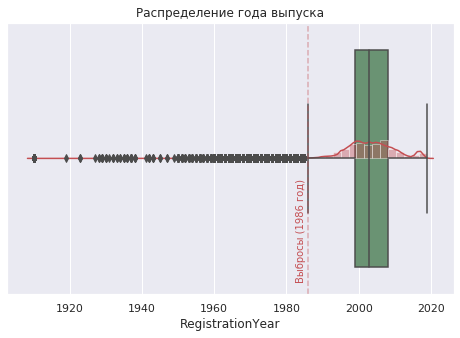

In [45]:
sns.set()
fig, ax = plt.subplots()

_treshhold = round(low_treshhold(data.RegistrationYear))
sns.distplot(data.RegistrationYear, color='r', ax=ax)
sns.boxplot(data.RegistrationYear, color='g', saturation=0.5, ax=ax)
plt.axvline(_treshhold, color='r', linestyle='dashed', alpha=.4)

ax.text(_treshhold-2, -.45, str('Выбросы ({} год)'.format(_treshhold)),
        color='r', size=10, rotation= 90, ha="center")

ax.invert_yaxis()

plt.title('Распределение года выпуска')
plt.show()

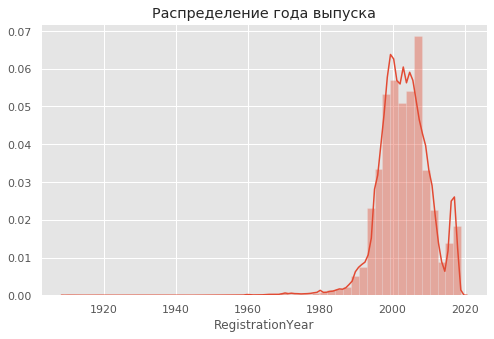

In [46]:
matplotlib.style.use('ggplot')
sns.distplot(data.RegistrationYear)
plt.title('Распределение года выпуска')
plt.show()

In [47]:
data = data.loc[data.RegistrationYear > _treshhold]
del _treshhold

### 1.3.2. Стоимость авто

In [48]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NotRepaired,NumberOfPictures,PostalCode
count,326531.00,326531.00,326531.00,326531.00,326531.00,326531.00,326531.00,326531.00
mean,4389.69,2003.61,117.47,129220.14,5.79,0.10,0.00,50640.98
std,4469.07,6.31,49.42,36670.49,3.70,0.30,0.00,25773.31
min,0.00,1987.00,1.00,5000.00,0.00,0.00,0.00,1067.00
25%,1100.00,1999.00,75.00,125000.00,3.00,0.00,0.00,30179.00
50%,2700.00,2003.00,109.00,150000.00,6.00,0.00,0.00,49477.00
75%,6300.00,2008.00,143.00,150000.00,9.00,0.00,0.00,71263.00
max,20000.00,2019.00,333.00,150000.00,12.00,1.00,0.00,99998.00


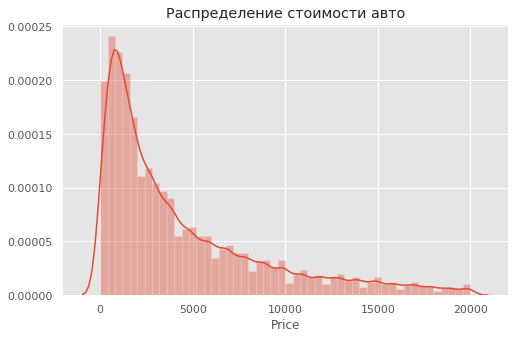

In [49]:
sns.distplot(data.Price)
plt.title('Распределение стоимости авто')
plt.show()

т.к. распределение близко к логнормальному, то возьмем от него логарифм и вновь построим график

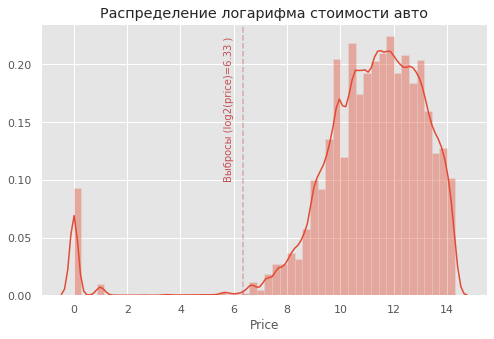

In [50]:
fig, ax = plt.subplots()

sns.distplot(np.log2(data.Price+1), ax=ax)
plt.title('Распределение логарифма стоимости авто')
plt.axvline(low_treshhold(np.log2(data.Price+1)), color='r', linestyle='dashed', alpha=.4)
ax.text(low_treshhold(np.log2(data.Price+1))-.5, .1, str('Выбросы (log2(price)={:.2f} )'\
                                                          .format(low_treshhold(np.log2(data.Price+1)))),
        color='r', size=10, rotation= 90, ha="center")

plt.show()

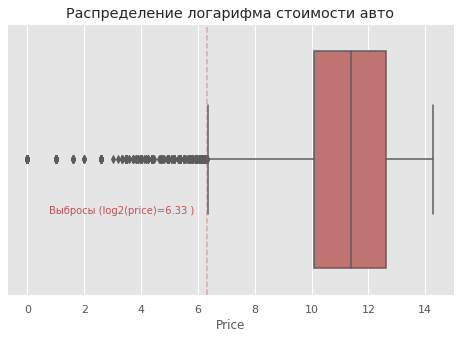

In [51]:
fig, ax = plt.subplots()

sns.boxplot(np.log2(data.Price+1), ax=ax, color='#CC6666')
plt.title('Распределение логарифма стоимости авто')
plt.axvline(low_treshhold(np.log2(data.Price+1)), color='r', linestyle='dashed', alpha=.4)
ax.text(low_treshhold(np.log2(data.Price+1))-3, .2, str('Выбросы (log2(price)={:.2f} )'\
                                                          .format(low_treshhold(np.log2(data.Price+1)))),
        color='r', size=10, rotation=0, ha="center")

plt.show()

Удалим стоимость автомобилей ниже границы `low_treshhold(np.log2(data.Price+1))`, при этом ожидаем, что удалятся аномально низкие и нулевые значения

In [52]:
data = data.loc[np.log2(data.Price+1) > low_treshhold(np.log2(data.Price+1))]

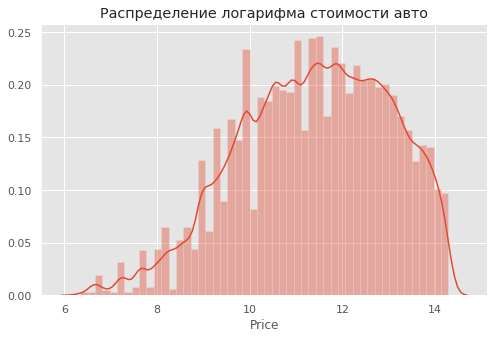

In [53]:
fig, ax = plt.subplots()

sns.distplot(np.log2(data.Price+1), ax=ax)
plt.title('Распределение логарифма стоимости авто')

plt.show()

In [54]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NotRepaired,NumberOfPictures,PostalCode
count,316190.00,316190.00,316190.00,316190.00,316190.00,316190.00,316190.00,316190.00
mean,4533.14,2003.67,117.65,129269.33,5.85,0.10,0.00,50803.39
std,4469.45,6.26,49.42,36347.23,3.67,0.30,0.00,25731.14
min,80.00,1987.00,1.00,5000.00,0.00,0.00,0.00,1067.00
25%,1200.00,1999.00,75.00,125000.00,3.00,0.00,0.00,30519.00
50%,2890.00,2003.00,109.00,150000.00,6.00,0.00,0.00,49584.00
75%,6500.00,2008.00,143.00,150000.00,9.00,0.00,0.00,71384.00
max,20000.00,2019.00,333.00,150000.00,12.00,1.00,0.00,99998.00


### 1.3.3. Стоимость авто в зависимости от года

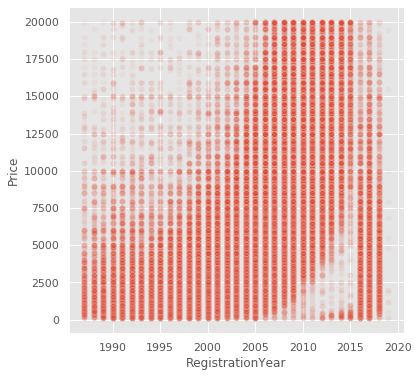

In [55]:
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=data.RegistrationYear, y=data.Price, alpha=.05)

plt.show()

In [56]:
data.loc[(data.RegistrationYear < 2000) & (data.Price > 10000)].describe(include=[object])

,VehicleType,Gearbox,Model,FuelType,Brand
count,893,893,893,893,893
unique,8,2,56,3,28
top,convertible,manual,other,petrol,mercedes_benz
freq,329,520,225,723,287


Проверим распределение для 5-ти наиболее популярных момелей

In [57]:
_ = data.groupby(by=['Brand', 'Model'])['Price', 'RegistrationYear']\
        .count()\
        .sort_values(by='Price', ascending=False)\
        .index

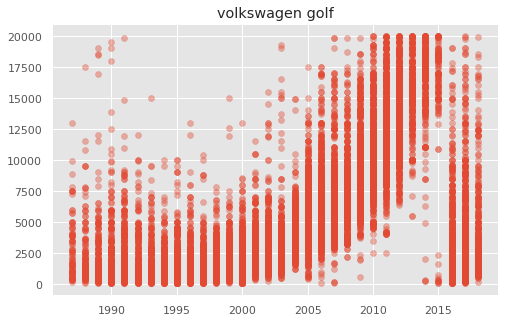

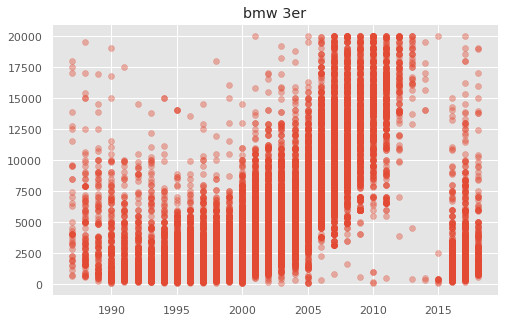

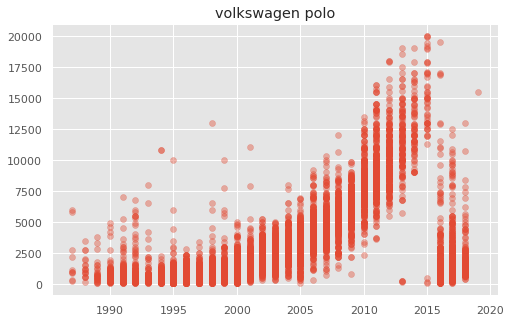

In [58]:
for elem in _[:3]:    
       
    plt.scatter(x=data.loc[(data.Brand == elem[0]) & (data.Model == elem[1]), 'RegistrationYear'],
                y=data.loc[(data.Brand == elem[0]) & (data.Model == elem[1]), 'Price'],
                alpha=.4)
    plt.title(elem[0] + ' ' + elem[1])

    plt.show()

Построим графики для 5-ти случайных моделей автомобилей

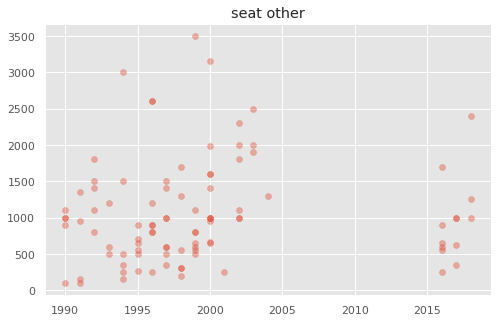

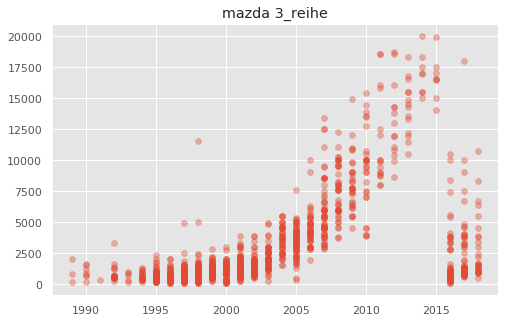

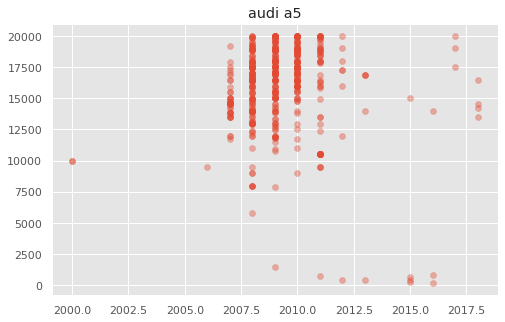

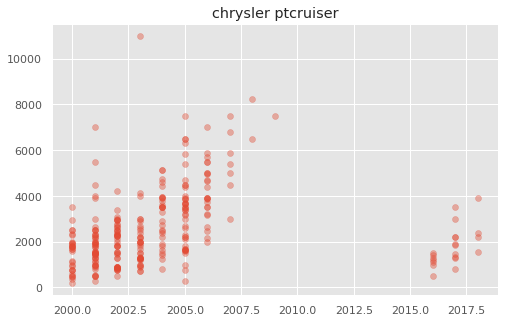

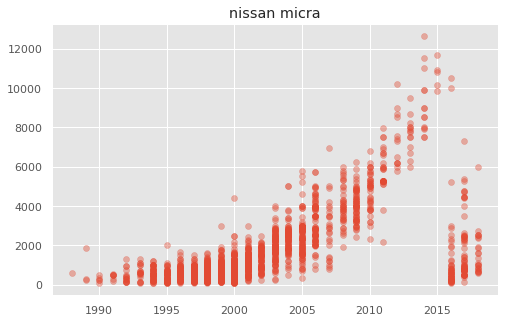

In [59]:
for elem in _[np.random.randint(0, len(_), 5)]:    
       
    plt.scatter(x=data.loc[(data.Brand == elem[0]) & (data.Model == elem[1]), 'RegistrationYear'],
                y=data.loc[(data.Brand == elem[0]) & (data.Model == elem[1]), 'Price'],
                alpha=.4)
    plt.title(elem[0] + ' ' + elem[1])

    plt.show()

Наблюдается резкое снижение цены после 2015 года, возможно это ошибки при выгрузке/записе данных, возможно повлияли иные факторы уже непосредственно связанные с ценообразованием, т.к. возможности уточнить у нас нет будем продолжать анализ с имеющимися данными<br/>
Также наблюдается сильный разброс цен для одного и того же года, возможно это является причиной влияния неучтенного в датасете фактора

In [60]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NotRepaired,NumberOfPictures,PostalCode
count,316190.00,316190.00,316190.00,316190.00,316190.00,316190.00,316190.00,316190.00
mean,4533.14,2003.67,117.65,129269.33,5.85,0.10,0.00,50803.39
std,4469.45,6.26,49.42,36347.23,3.67,0.30,0.00,25731.14
min,80.00,1987.00,1.00,5000.00,0.00,0.00,0.00,1067.00
25%,1200.00,1999.00,75.00,125000.00,3.00,0.00,0.00,30519.00
50%,2890.00,2003.00,109.00,150000.00,6.00,0.00,0.00,49584.00
75%,6500.00,2008.00,143.00,150000.00,9.00,0.00,0.00,71384.00
max,20000.00,2019.00,333.00,150000.00,12.00,1.00,0.00,99998.00


Заменим нулевые значения Месяцев на 1

In [61]:
data.loc[data.RegistrationMonth == 0, 'RegistrationMonth'] = 1

In [62]:
print('Удалили', round((1 - data.shape[0] / DATA_ORIGIN_SIZE)*100, 2), '% данных при обработке в целом')

Удалили 10.77 % данных при обработке в целом


## 1.4. Подготовим выборки для обучения моделей <a id='section1.4'></a>

Далее не будем использовать столбцы `DateCrawled`, `DateCreated`, `LastSeen` т.к. они не известны пользователю при вводе информации о автомобиле

А также удалим признак `NumberOfPictures` т.к. он не содержит ни какой информации

In [63]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [64]:
cols = ['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
        'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
        'NotRepaired', 'PostalCode'
       ]

Конвертируем категориальные значения в переменные-индикаторы

In [65]:
df_lin = pd.get_dummies(data[cols])

Для линейной модели

In [66]:
X_lin = df_lin.drop(columns='Price', axis=1)
y_lin = df_lin.Price

In [67]:
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X_lin, y_lin, test_size=0.33, random_state=42)

Для моделей градиентного бустинга

In [68]:
df_gb = data[cols]

In [69]:
cols_categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']

In [70]:
df_gb[cols_categorical] = df_gb[cols_categorical].astype('category')

In [71]:
X = df_gb.drop(columns='Price', axis=1)
y = df_gb.Price

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [77]:
pd.set_option('display.max_columns', 100)
X_lin.head(3)

,RegistrationYear,Power,Kilometer,RegistrationMonth,NotRepaired,PostalCode,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_auto,Gearbox_manual,Model_100,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,...,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_alfa_romeo,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
0,1993,95.00,150000,1,0,70435,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2011,190.00,125000,5,1,66954,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2004,163.00,125000,8,0,90480,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Вывод

1. Данные изучены и подготовлены - пропуски заполнены, обработаны выбросы и артефактные значения, удалены дубликаты
2. Наблюдается не совсем логическое поведение цены на модели автомобилей (после 2015 автомобили стоят дешевле чем более старые аналоги)
3. Также отмечены наличие выбросов для автомобилей одной модели и одного и того же года, в работе принято не удалять эти значения, однако следовало бы проверить эти автомобили на наличие признаков, которые могут объяснить эти различия (например является ли эта модель GT или производился ли дополнительный тюнинг для автомобиля, сравнение комплектации)

# 2. Обучение моделей

Нипишим функцию для вычисления метрики rmse по которой будем сравнивать модели

## 2.1. Линейная регрессия <a id='section2.1'></a>

In [73]:
def rmse(model, X_test, y_test):
    start = timer()
    model_pred = model.predict(X_test)
    end = timer() - start
    rmse = np.sqrt(mean_squared_error(y_test, model_pred))
    return round(rmse), round(end)

In [74]:
linreg_model = LinearRegression()

In [75]:
%%time
start = timer()
linreg_model.fit(X_train_lin, y_train_lin)
linreg_time = round(timer() - start)

CPU times: user 17.3 s, sys: 4.87 s, total: 22.1 s
Wall time: 22.1 s


In [76]:
lireg_pred = linreg_model.predict(X_test_lin)

In [77]:
linreg_rmse, linreg_pred_time = rmse(linreg_model, X_test_lin, y_test_lin)

In [78]:
linreg_rmse

2554

In [79]:
linreg_pred_time

0

In [80]:
del df_lin, X_train_lin, X_test_lin, y_train_lin, y_test_lin

## 2.2. LightGBM <a id='section2.2'></a>

Подбор параметров сделан GridSearchCV, выбрана лучшая модель

```python
param_grid = {
    'learning_rate' : [0.01, 0.1, 1],
    'n_estimators'  : [20, 40, 100],
    'max_depth'     : [2, 4, 6, 8]
}

gbm_model = GridSearchCV(lgb.LGBMRegressor(random_state=42), param_grid, cv=3)

%%time
start = timer()

gbm_model.fit(X_train, y_train)

gbm_time = timer() - start

>>>
CPU times: user 2h 42min 29s, sys: 54.2 s, total: 2h 43min 24s
Wall time: 2h 44min 32s
```

In [81]:
gbm_model = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                              importance_type='split', learning_rate=0.1, max_depth=15,
                              min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
                              n_estimators=300, n_jobs=-1, num_leaves=200, objective=None,
                              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                              subsample=1.0, subsample_for_bin=150000, subsample_freq=0)

In [82]:
%%time
start = timer()

gbm_model.fit(X_train, y_train)

gbm_time = round(timer() - start)

CPU times: user 42.1 s, sys: 547 ms, total: 42.7 s
Wall time: 43.3 s


In [83]:
gbm_time

43

In [84]:
gbm_rmse, gbm_pred_time = rmse(gbm_model, X_test, y_test)

In [85]:
gbm_rmse

1469

In [86]:
gbm_pred_time

7

## 2.3. CatBoost <a id='section2.3'></a>

In [87]:
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cols_categorical)
test_pool = Pool(X_test, 
                 cat_features=cols_categorical) 

Также был сделан предварительный поиск параметров

```python
cbr_model = CatBoostRegressor(random_state=42, loss_function='RMSE')

grid = {'learning_rate': list(np.arange(0.01, 1.1, .2)),
        'depth'        : [4, 6, 10],
        'l2_leaf_reg'  : [1, 3, 5, 7, 9]     
       }
%%time
grid_search_result = cbr_model.grid_search(grid, 
                                           train_pool,
                                           plot=True)
>>>
CPU times: user 10h 53min 58s, sys: 1h 32min 25s, total: 12h 26min 24s
Wall time: 58min 46s

grid_search_result['params']
>>>
{'depth': 10, 'l2_leaf_reg': 7, 'learning_rate': 0.21}
```

In [88]:
%%time
start = timer()
cbr_model = CatBoostRegressor(random_state=42,
                              depth=10,
                              learning_rate=.21,
                              l2_leaf_reg=7,
                              loss_function='RMSE',
                              verbose=0                            
                             )

cbr_model.fit(train_pool)

cbr_time = round(timer() - start)

CPU times: user 16min 56s, sys: 1min 17s, total: 18min 13s
Wall time: 18min 16s


In [89]:
cbr_rmse, cbr_pred_time = rmse(cbr_model, test_pool, y_test)

In [90]:
cbr_rmse

1490

In [91]:
cbr_pred_time

3

In [92]:
models       = ['LinReg', 'LightGBM', 'CatBoost']
time_fit     = [linreg_time, gbm_time, cbr_time]
score        = [linreg_rmse, gbm_rmse, cbr_rmse]
time_predict = [linreg_pred_time, gbm_pred_time, cbr_pred_time]

for i in range(len(models)):
    print(f'Модель {models[i]}:')
    print(f'\tВремя обучения модели: {time_fit[i]} секунд')
    print(f'\tRMSE модели: {score[i]}')
    print()

Модель LinReg:
	Время обучения модели: 22 секунд
	RMSE модели: 2554

Модель LightGBM:
	Время обучения модели: 43 секунд
	RMSE модели: 1469

Модель CatBoost:
	Время обучения модели: 1097 секунд
	RMSE модели: 1490



# 3. Анализ моделей <a id='section3'></a>

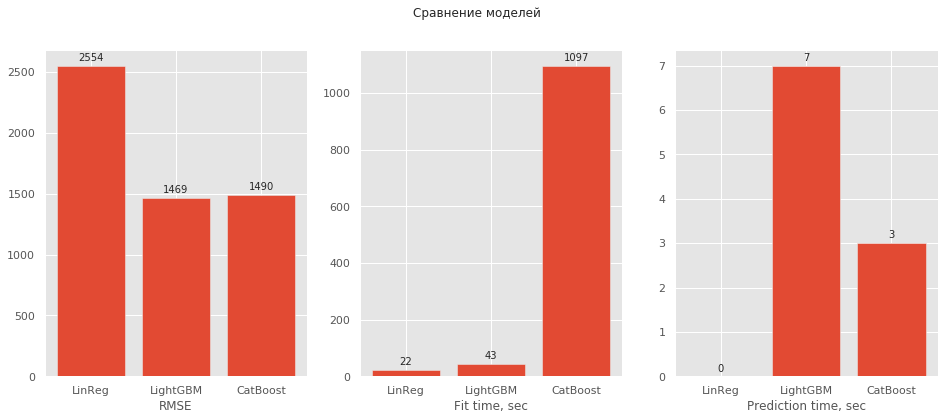

In [93]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle('Сравнение моделей')

rect1 = ax1.bar(x=models, height=score)
ax1.set_xlabel('RMSE')
    
rect2 = ax2.bar(x=models, height=time_fit)
ax2.set_xlabel('Fit time, sec')

rect3 = ax3.bar(x=models, height=time_predict)
ax3.set_xlabel('Prediction time, sec')

def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rect1, ax1)
autolabel(rect2, ax2)
autolabel(rect3, ax3)

                    
plt.show()

## Вывод

1. Качество моделей LightGBM и CatBoost приблизительно одинаковые, отличие составляет ~1,5%
2. Время обучения модели CatBoost отличается от других сравниваемых моделей
3. Наибольшее время предсказания наблюдается у LightGBM
4. Наиболее рационально для предсказания стоимости автомобилей выбрать модель LightGBM